In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests as req
from citipy import citipy
from datetime import datetime
from config import weather_api_key

In [2]:
def build_url(city):
    base_url = "http://api.openweathermap.org/data/2.5/weather?"
    return base_url + "units=Imperial" + "&APPID=" + weather_api_key + "&q=" + city

In [3]:
url = "http://api.openweathermap.org/data/2.5/weather?" + "units=Imperial" + "&APPID=" + weather_api_key

In [4]:
cities = ["Pittsburgh", "Austin", "New  York", "Los Angeles", "Seattle"]
for city in cities:
    try:
        city_url = url + "&q=" + city
        weather = req.get(city_url).json()
        temp = weather['main']['temp']
    except KeyError:
        print("KeyError received for " + city)
        continue
    print("It is currently " + str(temp) + " degrees in " + city)

        

It is currently 75.36 degrees in Pittsburgh
It is currently 77.22 degrees in Austin
KeyError received for New  York
It is currently 67.98 degrees in Los Angeles
It is currently 44.51 degrees in Seattle


# Create zipped lat_lngs[] with 1500 random lat & lon values

In [5]:
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)
lat_lngs

# create coordinates[] from zipped lat_lngs[]

In [6]:
coordinates = list(lat_lngs)

# Use citipy to find nearest_city for coordinates[] and append to cities[]

In [7]:
cities = []
for coordinate in coordinates:
    x = coordinate[0]
    y = coordinate[1]
    city_name    = citipy.nearest_city(coordinate[0], coordinate[1]).city_name
    country_code = citipy.nearest_city(coordinate[0], coordinate[1]).country_code
    #print(f"{x} {y} {city_name} {country_code}")
    if city_name not in cities:
        cities.append(city_name)
print(len(cities))

604


# Append rows to city_data[] for each city

In [8]:
# Create an empty list to hold the weather data.
city_data = []
# Print the beginning of the logging.
print("Beginning Data Retrieval     ")
print("-----------------------------")

# Create counters.
record_count = 1
set_count = 1

# Loop through all the cities in the list.
for i, city in enumerate(cities):

    # Group cities in sets of 50 for logging purposes.
    if (i % 50 == 0 and i >= 50):
        set_count += 1
        record_count = 1
    # Create endpoint URL with each city.
    city_url = url + "&q=" + city.replace(" ","+")
    #print(city_url)

    # Log the URL, record, and set numbers and the city.
    print(f"Processing Record {record_count} of Set {set_count} | {city}")
    # Add 1 to the record count.
    record_count += 1
    
    # Run an API request for each of the cities.
    try:
        # Parse the JSON and retrieve data.
        city_weather = req.get(city_url).json()
        # Parse out the needed data.
        city_lat = city_weather["coord"]["lat"]
        city_lng = city_weather["coord"]["lon"]
        city_max_temp = city_weather["main"]["temp_max"]
        city_humidity = city_weather["main"]["humidity"]
        city_clouds = city_weather["clouds"]["all"]
        city_wind = city_weather["wind"]["speed"]
        city_country = city_weather["sys"]["country"]
        # Convert the date to ISO standard.
        city_date = datetime.utcfromtimestamp(city_weather["dt"]).strftime('%Y-%m-%d %H:%M:%S')
        # Append the city information into city_data list.
        city_data.append({"City": city.title(),
                          "Lat": city_lat,
                          "Lng": city_lng,
                          "Max Temp": city_max_temp,
                          "Humidity": city_humidity,
                          "Cloudiness": city_clouds,
                          "Wind Speed": city_wind,
                          "Country": city_country,
                          "Date": city_date})

        #print("city="+city
        #      +", lat="+str(city_weather['coord']['lat'])
        #      +", lon="+str(city_weather['coord']['lon']))  

    # If an error is experienced, skip the city.
    except:
        print("City not found. Skipping...")
        pass

# Indicate that Data Loading is complete.
print("-----------------------------")
print("Data Retrieval Complete      ")
print("-----------------------------")

Beginning Data Retrieval     
-----------------------------
Processing Record 1 of Set 1 | visnes
Processing Record 2 of Set 1 | whitehorse
Processing Record 3 of Set 1 | barsovo
Processing Record 4 of Set 1 | yellowknife
Processing Record 5 of Set 1 | albany
Processing Record 6 of Set 1 | fortuna
Processing Record 7 of Set 1 | wanning
Processing Record 8 of Set 1 | dikson
Processing Record 9 of Set 1 | saint-philippe
Processing Record 10 of Set 1 | avarua
Processing Record 11 of Set 1 | muros
Processing Record 12 of Set 1 | walvis bay
Processing Record 13 of Set 1 | mataura
Processing Record 14 of Set 1 | mys shmidta
City not found. Skipping...
Processing Record 15 of Set 1 | esperance
Processing Record 16 of Set 1 | jiddah
City not found. Skipping...
Processing Record 17 of Set 1 | east london
Processing Record 18 of Set 1 | bredasdorp
Processing Record 19 of Set 1 | santa rosa
Processing Record 20 of Set 1 | najran
Processing Record 21 of Set 1 | salalah
Processing Record 22 of Set 

Processing Record 41 of Set 4 | aqtobe
Processing Record 42 of Set 4 | guekedou
City not found. Skipping...
Processing Record 43 of Set 4 | hovd
Processing Record 44 of Set 4 | marcona
City not found. Skipping...
Processing Record 45 of Set 4 | northam
Processing Record 46 of Set 4 | kikwit
Processing Record 47 of Set 4 | tuatapere
Processing Record 48 of Set 4 | jamestown
Processing Record 49 of Set 4 | ribeira grande
Processing Record 50 of Set 4 | gurgan
City not found. Skipping...
Processing Record 1 of Set 5 | kologriv
Processing Record 2 of Set 5 | derzhavinsk
Processing Record 3 of Set 5 | hami
Processing Record 4 of Set 5 | necaxa
Processing Record 5 of Set 5 | bose
Processing Record 6 of Set 5 | dicabisagan
Processing Record 7 of Set 5 | coquimbo
Processing Record 8 of Set 5 | bubaque
Processing Record 9 of Set 5 | mehamn
Processing Record 10 of Set 5 | roma
Processing Record 11 of Set 5 | arraial do cabo
Processing Record 12 of Set 5 | nizhneyansk
City not found. Skipping...


Processing Record 31 of Set 8 | takoradi
Processing Record 32 of Set 8 | pitlochry
Processing Record 33 of Set 8 | jahanabad
Processing Record 34 of Set 8 | zabaykalsk
Processing Record 35 of Set 8 | tianpeng
Processing Record 36 of Set 8 | sao joao da barra
Processing Record 37 of Set 8 | poya
Processing Record 38 of Set 8 | maragogi
Processing Record 39 of Set 8 | samusu
City not found. Skipping...
Processing Record 40 of Set 8 | sao francisco
Processing Record 41 of Set 8 | narsaq
Processing Record 42 of Set 8 | isla vista
Processing Record 43 of Set 8 | buala
Processing Record 44 of Set 8 | jieznas
Processing Record 45 of Set 8 | soskovo
Processing Record 46 of Set 8 | utena
Processing Record 47 of Set 8 | kinsale
Processing Record 48 of Set 8 | pevek
Processing Record 49 of Set 8 | san ramon
Processing Record 50 of Set 8 | krasnyy sulin
Processing Record 1 of Set 9 | bull savanna
Processing Record 2 of Set 9 | aguililla
Processing Record 3 of Set 9 | vao
Processing Record 4 of Set

Processing Record 21 of Set 12 | afanasyevo
City not found. Skipping...
Processing Record 22 of Set 12 | palmer
Processing Record 23 of Set 12 | flekkefjord
Processing Record 24 of Set 12 | cervia
Processing Record 25 of Set 12 | dabat
Processing Record 26 of Set 12 | pacific grove
Processing Record 27 of Set 12 | sault sainte marie
Processing Record 28 of Set 12 | aflu
City not found. Skipping...
Processing Record 29 of Set 12 | hearst
Processing Record 30 of Set 12 | nikolayevsk-na-amure
Processing Record 31 of Set 12 | russell
Processing Record 32 of Set 12 | halifax
Processing Record 33 of Set 12 | tabiauea
City not found. Skipping...
Processing Record 34 of Set 12 | paradwip
City not found. Skipping...
Processing Record 35 of Set 12 | teya
Processing Record 36 of Set 12 | ridgecrest
Processing Record 37 of Set 12 | neiafu
Processing Record 38 of Set 12 | nishihara
Processing Record 39 of Set 12 | moose factory
Processing Record 40 of Set 12 | bharatpur
Processing Record 41 of Set 

# Create city_data_df DataFrame

In [9]:
city_data_df = pd.DataFrame(city_data)
city_data_df.head(10)

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Visnes,59.3556,5.2242,37.00,80,75,28.77,NO,2021-04-07 17:30:48
1,Whitehorse,60.7161,-135.0538,10.99,51,20,5.75,CA,2021-04-07 17:30:48
2,Barsovo,61.1667,73.1667,32.00,93,75,6.71,RU,2021-04-07 17:30:48
3,Yellowknife,62.4560,-114.3525,18.00,67,90,13.80,CA,2021-04-07 17:30:05
4,Albany,42.6001,-73.9662,66.99,35,39,1.99,US,2021-04-07 17:30:42
5,Fortuna,40.5982,-124.1573,50.00,87,90,8.05,US,2021-04-07 17:30:49
6,Wanning,18.8003,110.3967,73.45,90,20,0.38,CN,2021-04-07 17:30:49
7,Dikson,73.5069,80.5464,-0.54,89,52,3.76,RU,2021-04-07 17:30:50
8,Saint-Philippe,-21.3585,55.7679,78.80,83,20,4.61,RE,2021-04-07 17:30:50
9,Avarua,-21.2078,-159.7750,80.60,74,90,6.91,CK,2021-04-07 17:30:50


In [10]:
new_column_order = ["City", "Country", "Date", "Lat", "Lng", "Max Temp", "Humidity", "Cloudiness", "Wind Speed"]
city_data_df = city_data_df[new_column_order]
city_data_df.head()

,City,Country,Date,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed
0,Visnes,NO,2021-04-07 17:30:48,59.3556,5.2242,37.00,80,75,28.77
1,Whitehorse,CA,2021-04-07 17:30:48,60.7161,-135.0538,10.99,51,20,5.75
2,Barsovo,RU,2021-04-07 17:30:48,61.1667,73.1667,32.00,93,75,6.71
3,Yellowknife,CA,2021-04-07 17:30:05,62.4560,-114.3525,18.00,67,90,13.80
4,Albany,US,2021-04-07 17:30:42,42.6001,-73.9662,66.99,35,39,1.99


# Output cities.csv

In [11]:
# Create the output file (CSV).
output_data_file = "weather_data/cities.csv"
# Export the City_Data into a CSV.
city_data_df.to_csv(output_data_file, index_label="City_ID")

# Get parameters for scatter plots from city_data_df

In [12]:
lats = city_data_df["Lat"]
max_temps = city_data_df["Max Temp"]
humidity = city_data_df["Humidity"]
cloudiness = city_data_df["Cloudiness"]
wind_speed = city_data_df["Wind Speed"]

# Latitude vs. Max Temp scatter plot

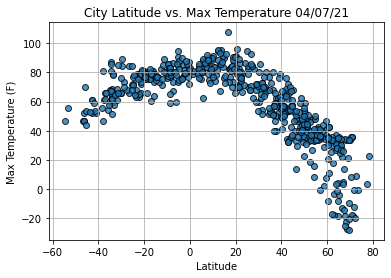

In [13]:
# Import time module
import time

# Build the scatter plot for latitude vs. max temperature.
plt.scatter(lats,
            max_temps,
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="Cities")

# Incorporate the other graph properties.
plt.title(f"City Latitude vs. Max Temperature "+ time.strftime("%x"))
plt.ylabel("Max Temperature (F)")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure.
plt.savefig("weather_data/Fig1.png")

# Show plot.
plt.show()

# Latitude vs. Humidity scatter plot

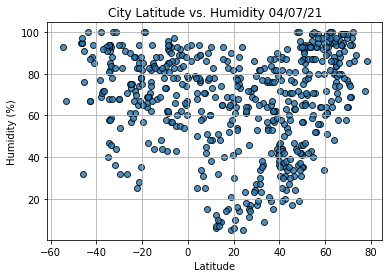

In [14]:
# Build the scatter plots for latitude vs. humidity.
plt.scatter(lats,
            humidity,
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="Cities")

# Incorporate the other graph properties.
plt.title(f"City Latitude vs. Humidity "+ time.strftime("%x"))
plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")
plt.grid(True)
# Save the figure.
plt.savefig("weather_data/Fig2.png")
# Show plot.
plt.show()

# Latitude vs. Cloudiness scatter plot

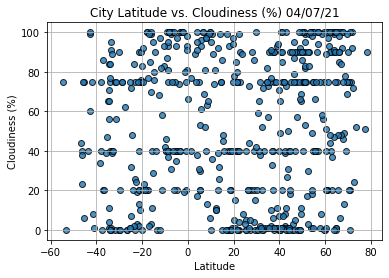

In [15]:
# Build the scatter plots for latitude vs. cloudiness.
plt.scatter(lats,
            cloudiness,
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="Cities")

# Incorporate the other graph properties.
plt.title(f"City Latitude vs. Cloudiness (%) "+ time.strftime("%x"))
plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")
plt.grid(True)
# Save the figure.
plt.savefig("weather_data/Fig3.png")
# Show plot.
plt.show()

# Latitude vs. Wind Speed scatter plot

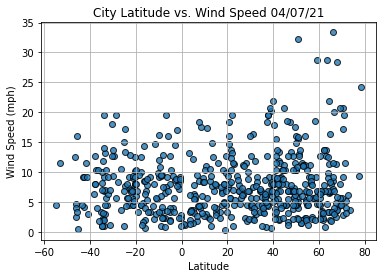

In [16]:
# Build the scatter plots for latitude vs. wind speed.
plt.scatter(lats,
            wind_speed,
            edgecolor="black", linewidths=1, marker="o",
            alpha=0.8, label="Cities")

# Incorporate the other graph properties.
plt.title(f"City Latitude vs. Wind Speed "+ time.strftime("%x"))
plt.ylabel("Wind Speed (mph)")
plt.xlabel("Latitude")
plt.grid(True)
# Save the figure.
plt.savefig("weather_data/Fig4.png")
# Show plot.
plt.show()